In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Bucharest record min and max temperatures, adjusted according to source
# Source: https://www.extremeweatherwatch.com/cities/bucharest/lowest-temperatures
BUC_MIN_TEMP = -35
BUC_MAX_TEMP = 45

N_LAGS = 7


def clean_data(df):
    # Set the date as the index
    index = pd.to_datetime(df[["Year", "Month", "Day"]])
    df.set_index(index, inplace=True)

    # Clean rows
    # Sea Level Pressure, gets dropped, too many 0, not enough relevant info
    corrupted = df[df["Sea_Level_Pressure"] == "True"]
    df.drop(index=corrupted.index, inplace=True)
    df.drop("Sea_Level_Pressure", axis=1, inplace=True)

    # Humidity Average, 11 rows with NaN, can drop them
    corrupted = df[df["Humidity_Avg"].isna()]
    df.drop(index=corrupted.index, inplace=True)

    # Precipitation Total, fill Nan with 0
    df["Precipitation_Total"].fillna("0", inplace=True)

    # Visibility Average, gets dropped, too many NaN values > 10%
    df.drop("Visibility_Avg", axis=1, inplace=True)

    # Wind Max, contains mostly NaN values, can drop
    # We have Wind Sustained Max which is clean
    df.drop("Wind_Max", axis=1, inplace=True)

    return df


def normalize_temp_data(df):
    # Create new dataframe
    scaled = df.copy(deep=True)

    # Scale with record min and max
    temp_scaler = MinMaxScaler()
    temp_scaler.fit(np.array((BUC_MIN_TEMP, BUC_MAX_TEMP)).reshape(-1, 1))

    cols = temp_cols
    temp_data = np.array(df[cols]).T
    scaled = df.copy(deep=True)
    temp_scaled = [temp_scaler.transform(X.reshape(-1, 1)) for X in temp_data]
    for idx, col in enumerate(cols):
        scaled[col] = temp_scaled[idx]
    return scaled, temp_scaler


def normalize_data(df):
    scaler = MinMaxScaler()
    cols = misc_cont_cols
    df[cols] = scaler.fit_transform(df[cols])
    return df, scaler


def build_set(ds, lags=10):
    train = []
    true = []
    for idx in range(len(ds) - lags):
        current = ds[idx : idx + lags]
        pred = ds[idx + lags][temp_avg_idx]
        train.append(current)
        true.append(pred)

    train = torch.cat([t for t in train]).reshape(-1, lags, ds.shape[1])
    true = torch.tensor(true).reshape(-1, 1)
    return train, true


df = pd.read_csv("data.csv")
df = clean_data(df)

# Boolean columns
cat_cols = [col for col in df.columns if col.startswith("Is")]
# Continous columns
cont_cols = list(
    set(df.columns) - set(cat_cols) - set(["Year", "Month", "Day"])
)
# Temperature columns
temp_cols = [col for col in cont_cols if col.startswith("Temperature")]
# Miscellaneous continuous columns -> Humidity, Precipitation, Wind
misc_cont_cols = list(set(cont_cols) - set(temp_cols))

# Set correct datatypes
df[cont_cols] = df[cont_cols].astype("float")

# Scale temperatures on the whole dataset
scaled, temp_scaler = normalize_temp_data(df)

valid_start = "2022-01-01"
train_df = scaled[:valid_start][:-1]
valid_df = scaled[valid_start:]

# Scale the rest of the continous columns
train_df, scaler = normalize_data(train_df)
valid_df[misc_cont_cols] = scaler.transform(valid_df[misc_cont_cols])

# Convert to tensors
train_cont = torch.tensor(np.stack([train_df[cont_cols]]), dtype=torch.float)
train_cat = torch.tensor(np.stack([train_df[cat_cols]]), dtype=torch.float)
valid_cont = torch.tensor(np.stack([valid_df[cont_cols]]), dtype=torch.float)
valid_cat = torch.tensor(np.stack([valid_df[cat_cols]]), dtype=torch.float)

# Create a train and valid dataset
train_ds = torch.cat((train_cont, train_cat), dim=2).squeeze()
valid_ds = torch.cat((valid_cont, valid_cat), dim=2).squeeze()

temp_avg_idx = cont_cols.index("Temperature_Avg")

x_train, y_train = build_set(train_ds, N_LAGS)

# Add the last N_LAGS elements to valid_ds to ensure continuity
x_valid, y_valid = build_set(torch.cat((train_ds[-N_LAGS:], valid_ds)), N_LAGS)


/tmp/ipykernel_14531/3428451221.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[misc_cont_cols] = scaler.transform(valid_df[misc_cont_cols])


In [2]:
train_ds[-N_LAGS:]

tensor([[0.6216, 0.3318, 0.4750, 0.5325, 0.3419, 0.0000, 0.6150, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.9459, 0.3079, 0.4250, 0.4475, 0.4791, 0.0000, 0.5725, 1.0000, 1.0000,
         0.0000, 0.0000],
        [0.9865, 0.3662, 0.4250, 0.4363, 0.4349, 0.0195, 0.4400, 1.0000, 0.0000,
         0.0000, 0.0000],
        [1.0000, 0.0867, 0.4250, 0.4338, 0.1465, 0.0332, 0.4412, 1.0000, 1.0000,
         0.0000, 1.0000],
        [0.9865, 0.1136, 0.4162, 0.4275, 0.1977, 0.0000, 0.4375, 1.0000, 1.0000,
         0.0000, 1.0000],
        [1.0000, 0.1390, 0.4275, 0.4475, 0.2070, 0.0371, 0.4638, 1.0000, 0.0000,
         0.0000, 0.0000],
        [1.0000, 0.2242, 0.4500, 0.4737, 0.2767, 0.0039, 0.5088, 1.0000, 0.0000,
         0.0000, 1.0000]])

In [3]:
valid_ds[:N_LAGS]

tensor([[0.9324, 0.0867, 0.4625, 0.5238, 0.1372, 0.0019, 0.6000, 1.0000, 0.0000,
         0.0000, 1.0000],
        [0.8514, 0.1659, 0.4350, 0.5075, 0.1605, 0.0000, 0.5625, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.8514, 0.2242, 0.4650, 0.5225, 0.2628, 0.0000, 0.5813, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.7027, 0.1659, 0.4663, 0.5200, 0.2279, 0.0000, 0.6012, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7838, 0.2242, 0.4750, 0.5288, 0.2535, 0.0000, 0.6263, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7297, 0.2242, 0.4500, 0.5312, 0.2535, 0.0000, 0.6388, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.7568, 0.3318, 0.4563, 0.4750, 0.3140, 0.0000, 0.5638, 1.0000, 0.0000,
         0.0000, 0.0000]])

In [4]:
x_train[-2:]

tensor([[[0.6892, 0.1136, 0.3500, 0.3862, 0.1093, 0.0000, 0.4375, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.6757, 0.3318, 0.3663, 0.4512, 0.3698, 0.0000, 0.5400, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.6216, 0.3318, 0.4750, 0.5325, 0.3419, 0.0000, 0.6150, 1.0000,
          0.0000, 0.0000, 0.0000],
         [0.9459, 0.3079, 0.4250, 0.4475, 0.4791, 0.0000, 0.5725, 1.0000,
          1.0000, 0.0000, 0.0000],
         [0.9865, 0.3662, 0.4250, 0.4363, 0.4349, 0.0195, 0.4400, 1.0000,
          0.0000, 0.0000, 0.0000],
         [1.0000, 0.0867, 0.4250, 0.4338, 0.1465, 0.0332, 0.4412, 1.0000,
          1.0000, 0.0000, 1.0000],
         [0.9865, 0.1136, 0.4162, 0.4275, 0.1977, 0.0000, 0.4375, 1.0000,
          1.0000, 0.0000, 1.0000]],

        [[0.6757, 0.3318, 0.3663, 0.4512, 0.3698, 0.0000, 0.5400, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.6216, 0.3318, 0.4750, 0.5325, 0.3419, 0.0000, 0.6150, 1.0000,
          0.0000, 0.0000, 0.0000],
         [0.9459,

In [5]:
y_train[-2:]

tensor([[0.4475],
        [0.4737]])

In [6]:
valid_ds[:N_LAGS]

tensor([[0.9324, 0.0867, 0.4625, 0.5238, 0.1372, 0.0019, 0.6000, 1.0000, 0.0000,
         0.0000, 1.0000],
        [0.8514, 0.1659, 0.4350, 0.5075, 0.1605, 0.0000, 0.5625, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.8514, 0.2242, 0.4650, 0.5225, 0.2628, 0.0000, 0.5813, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.7027, 0.1659, 0.4663, 0.5200, 0.2279, 0.0000, 0.6012, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7838, 0.2242, 0.4750, 0.5288, 0.2535, 0.0000, 0.6263, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7297, 0.2242, 0.4500, 0.5312, 0.2535, 0.0000, 0.6388, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.7568, 0.3318, 0.4563, 0.4750, 0.3140, 0.0000, 0.5638, 1.0000, 0.0000,
         0.0000, 0.0000]])

In [7]:
x_valid[:2]

tensor([[[0.6216, 0.3318, 0.4750, 0.5325, 0.3419, 0.0000, 0.6150, 1.0000,
          0.0000, 0.0000, 0.0000],
         [0.9459, 0.3079, 0.4250, 0.4475, 0.4791, 0.0000, 0.5725, 1.0000,
          1.0000, 0.0000, 0.0000],
         [0.9865, 0.3662, 0.4250, 0.4363, 0.4349, 0.0195, 0.4400, 1.0000,
          0.0000, 0.0000, 0.0000],
         [1.0000, 0.0867, 0.4250, 0.4338, 0.1465, 0.0332, 0.4412, 1.0000,
          1.0000, 0.0000, 1.0000],
         [0.9865, 0.1136, 0.4162, 0.4275, 0.1977, 0.0000, 0.4375, 1.0000,
          1.0000, 0.0000, 1.0000],
         [1.0000, 0.1390, 0.4275, 0.4475, 0.2070, 0.0371, 0.4638, 1.0000,
          0.0000, 0.0000, 0.0000],
         [1.0000, 0.2242, 0.4500, 0.4737, 0.2767, 0.0039, 0.5088, 1.0000,
          0.0000, 0.0000, 1.0000]],

        [[0.9459, 0.3079, 0.4250, 0.4475, 0.4791, 0.0000, 0.5725, 1.0000,
          1.0000, 0.0000, 0.0000],
         [0.9865, 0.3662, 0.4250, 0.4363, 0.4349, 0.0195, 0.4400, 1.0000,
          0.0000, 0.0000, 0.0000],
         [1.0000,

In [8]:
y_valid[:2]

tensor([[0.5238],
        [0.5075]])

In [9]:
print(x_train.shape)
print(x_valid.shape)

torch.Size([1788, 7, 11])
torch.Size([361, 7, 11])


## Build LSTM model

In [10]:
x_train[0].shape

torch.Size([7, 11])

In [11]:
y_train[0]

tensor([0.2925])

In [12]:
import torch.nn as nn

NUM_LAYERS = 3
HIDDEN_SIZE = 128

lstm = nn.LSTM(input_size=train_ds.shape[1], hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
hidden = (
    torch.zeros(NUM_LAYERS, HIDDEN_SIZE),
    torch.zeros(NUM_LAYERS, HIDDEN_SIZE),
)

out, hidden = lstm(x_train[0], hidden)

dropout = nn.Dropout(0.5)

out = dropout(out)

fc = nn.Linear(in_features=HIDDEN_SIZE, out_features=1)

out = fc(out)

In [13]:
out.shape

torch.Size([7, 1])

In [14]:
out

tensor([[-0.0185],
        [-0.0359],
        [-0.0142],
        [-0.0674],
        [-0.0486],
        [-0.0361],
        [-0.0329]], grad_fn=<AddmmBackward0>)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=4, output_size=1, dropout=0.5):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, X, hidden):
        out, hidden = self.lstm(X, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        # Only care about last prediction
        return out[-1], hidden

    def initialize_hidden(self):
        hidden = (
            torch.zeros(self.num_layers, self.hidden_size).to(device),
            torch.zeros(self.num_layers, self.hidden_size).to(device),
        )
        return hidden

In [17]:
model = MyLSTM(input_size=train_ds.shape[1]).to(device)
model

MyLSTM(
  (lstm): LSTM(11, 128, num_layers=4, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
torch.cuda.memory_allocated()

1874944

In [19]:
count = 0
for p in model.parameters():
    print(p.shape)
    if p.requires_grad:
        print(p.numel())
        count += p.numel()
print('---------\nNumber of parameters:', count)

torch.Size([512, 11])
5632
torch.Size([512, 128])
65536
torch.Size([512])
512
torch.Size([512])
512
torch.Size([512, 128])
65536
torch.Size([512, 128])
65536
torch.Size([512])
512
torch.Size([512])
512
torch.Size([512, 128])
65536
torch.Size([512, 128])
65536
torch.Size([512])
512
torch.Size([512])
512
torch.Size([512, 128])
65536
torch.Size([512, 128])
65536
torch.Size([512])
512
torch.Size([512])
512
torch.Size([1, 128])
128
torch.Size([1])
1
---------
Number of parameters: 468609


In [20]:
# hidden = model.initialize_hidden()
# out, hidden = model.forward(x_train[0], hidden)

In [21]:
out

tensor([[-0.0185],
        [-0.0359],
        [-0.0142],
        [-0.0674],
        [-0.0486],
        [-0.0361],
        [-0.0329]], grad_fn=<AddmmBackward0>)

In [22]:
torch.cuda.is_available()

True

## Train the model

In [23]:
x_train.shape[0] // 300

5

In [24]:
for x, y in zip(x_train, y_train):
    break

print(x)
print(y)

tensor([[0.6757, 0.1659, 0.3625, 0.4125, 0.2465, 0.0000, 0.5000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.6081, 0.2526, 0.3625, 0.4175, 0.2419, 0.0000, 0.5163, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.6081, 0.1659, 0.3500, 0.4212, 0.1163, 0.0000, 0.5025, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.6622, 0.2242, 0.3462, 0.4125, 0.2116, 0.0000, 0.4950, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.6892, 0.5590, 0.4250, 0.4525, 0.2070, 0.0000, 0.4888, 1.0000, 1.0000,
         0.0000, 0.0000],
        [0.9054, 0.5262, 0.3125, 0.3875, 0.4047, 0.0312, 0.4675, 0.0000, 1.0000,
         0.0000, 0.0000],
        [0.8649, 0.2003, 0.2875, 0.3150, 0.2372, 0.0078, 0.3475, 0.0000, 1.0000,
         0.0000, 0.0000]])
tensor([0.2925])


In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
criterion(out, y).item()

/home/horia/master_siva/an2_sem1/ic3/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.10833178460597992

In [27]:
len(x_valid)

361

In [28]:
from collections import defaultdict

loss = defaultdict(list)

loss[0].append('ceva')

loss

defaultdict(list, {0: ['ceva']})

In [29]:
loss[5].append('da')
loss

defaultdict(list, {0: ['ceva'], 5: ['da']})

In [30]:
n = 50
l = len(str(n))
print(f"{n:{l}}")

50


In [31]:
import time
from collections import defaultdict

def train_model(model, train_valid: tuple, criterion, optimizer, epochs=50):
    start = time.time()

    train_loss = defaultdict(list)
    valid_loss = defaultdict(list)

    x_train, y_train, x_valid, y_valid = train_valid

    for epoch in range(epochs):
        hidden = model.initialize_hidden()
        sample = 0
        for X, y_true in zip(x_train, y_train):
            sample += 1

            X = X.to(device)
            y_true = y_true.to(device)

            # Reset hidden state
            hidden = tuple([state.data for state in hidden])

            optimizer.zero_grad()

            y_pred, hidden = model.forward(X, hidden)
            loss = criterion(y_pred, y_true)

            loss.backward()
            optimizer.step()

            if sample % 300 == 0:
                train_loss[epoch].append(loss.item())

                val_hidden = model.initialize_hidden()

                total_val_loss = 0

                model.eval()
                for X_val, y_val_true in zip(x_valid, y_valid):
                    X_val = X_val.to(device)
                    y_val_true = y_val_true.to(device)

                    val_hidden = tuple([state.data for state in val_hidden])

                    y_val_pred, val_hidden = model.forward(X_val, val_hidden)
                    val_loss = criterion(y_val_pred, y_val_true)

                    total_val_loss += val_loss.item()

                avg_loss = total_val_loss / len(x_valid)
                valid_loss[epoch].append(avg_loss)

                model.train()

                print(f"Epoch: {epoch:{len(str(epochs))}} Sample: {sample:{len(str(x_train.shape[0]))}} Train Loss: {loss.item():3.8f} Avg Valid Loss: {avg_loss}")

    end = time.time()
    print(f"Duration = {end - start} seconds")

    return train_loss, valid_loss

In [32]:
train_loss, valid_loss = train_model(model, (x_train, y_train, x_valid, y_valid), criterion, optimizer, epochs=10)

Epoch:  0 Sample:  300 Train Loss: 0.00013301 Avg Valid Loss: 0.019230159879201455
Epoch:  0 Sample:  600 Train Loss: 0.00008512 Avg Valid Loss: 0.02301890809327961
Epoch:  0 Sample:  900 Train Loss: 0.01347268 Avg Valid Loss: 0.020197028011631677
Epoch:  0 Sample: 1200 Train Loss: 0.00309737 Avg Valid Loss: 0.017980020798573238
Epoch:  0 Sample: 1500 Train Loss: 0.00369699 Avg Valid Loss: 0.022369278002289005
Epoch:  1 Sample:  300 Train Loss: 0.00875286 Avg Valid Loss: 0.012980563746236976
Epoch:  1 Sample:  600 Train Loss: 0.00379252 Avg Valid Loss: 0.03904289389283848
Epoch:  1 Sample:  900 Train Loss: 0.00425653 Avg Valid Loss: 0.02138661488850336
Epoch:  1 Sample: 1200 Train Loss: 0.00309960 Avg Valid Loss: 0.01909612338741273
Epoch:  1 Sample: 1500 Train Loss: 0.00075625 Avg Valid Loss: 0.023136312700647216
Epoch:  2 Sample:  300 Train Loss: 0.00057610 Avg Valid Loss: 0.01402631218137083
Epoch:  2 Sample:  600 Train Loss: 0.00040095 Avg Valid Loss: 0.035322411872887156
Epoch:  2

In [33]:
tloss = [np.array(v).sum() / len(v) for k,v in train_loss.items()]

In [34]:
vloss = [np.array(v).sum() / len(v) for k,v in valid_loss.items()]

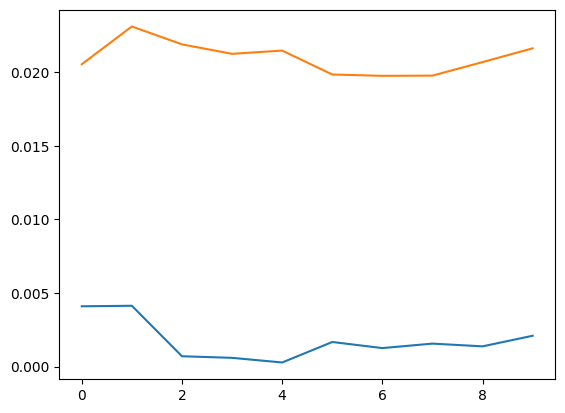

In [35]:
import matplotlib.pyplot as plt

plt.plot(tloss)
plt.plot(vloss)